## Perceptrón multicapa
Entrenar un modelo de red neuronal que aprenda a predecir la altura de un proyectil en cualquier instante del tiempo. <br>
$$ x_t = v_0 \cdot \cos(\theta) \cdot t$$
$$ y_t = v_0 \cdot \sin(\theta) \cdot t - \frac{1}{2} g \cdot t^2 $$
### Librerías

In [41]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Cargar los datos de entrenamiento

In [32]:
datos = pd.read_csv('datos_tiro_parabolico.csv')

X = torch.tensor(datos[['x']].values, dtype=torch.float32)
y = torch.tensor(datos[['y']].values, dtype=torch.float32)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Definir y configurar el modelo

In [33]:
class TPModel(nn.Module):
    def __init__(self):
        super(TPModel, self).__init__()
        self.hidden = nn.Linear(1, 16) 
        self.hidden2= nn.Linear(16,8)
        self.output = nn.Linear(8, 1)  
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.activation(self.hidden(x))
        x = self.activation(self.hidden2(x))
        x = self.output(x)
        return x

model = TPModel()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.1)

In [34]:
losses = []
r2_scores = []

for epoch in range(10000):  
    outputs = model(X)
    loss = criterion(outputs, y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Calcular R²
    ss_total = torch.sum((y - y.mean())**2)
    ss_res = torch.sum((y - outputs)**2)
    r2 = 1 - ss_res / ss_total
    r2_scores.append(r2.item())

    losses.append(loss.item())

    if (epoch + 1) % 1000 == 0:
        print(f"Epoch [{epoch+1}/10000] - Loss: {loss.item():.4f}, R²: {r2.item():.4f}")

Epoch [1000/10000] - Loss: 0.0193, R²: 0.9673
Epoch [2000/10000] - Loss: 0.0025, R²: 0.9957
Epoch [3000/10000] - Loss: 0.0048, R²: 0.9919
Epoch [4000/10000] - Loss: 0.0047, R²: 0.9921
Epoch [5000/10000] - Loss: 0.0035, R²: 0.9941
Epoch [6000/10000] - Loss: 0.0020, R²: 0.9965
Epoch [7000/10000] - Loss: 0.0014, R²: 0.9977
Epoch [8000/10000] - Loss: 0.0026, R²: 0.9955
Epoch [9000/10000] - Loss: 0.0024, R²: 0.9960
Epoch [10000/10000] - Loss: 0.0009, R²: 0.9984


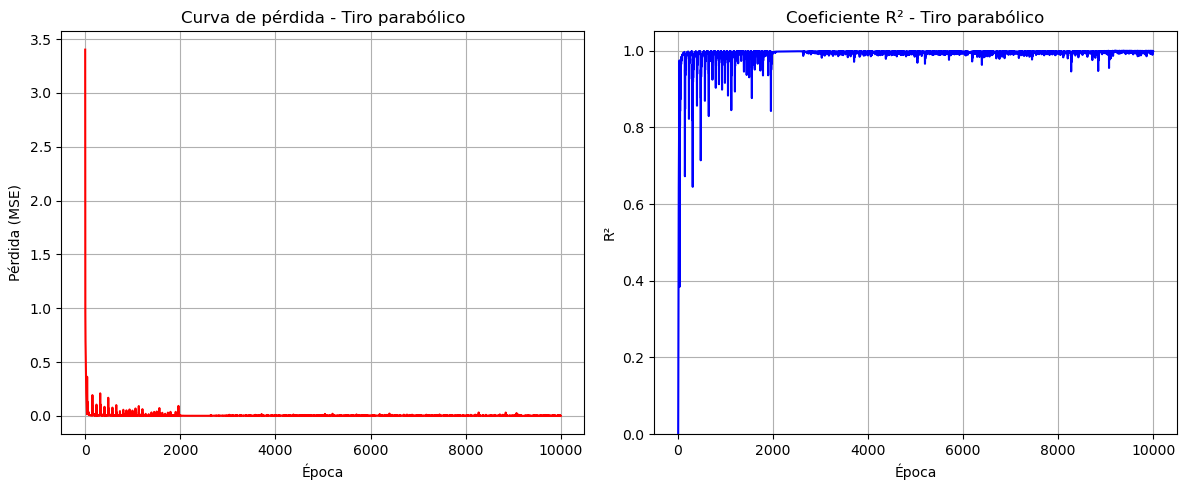


Predicciones finales:
Entrada: [0.0] → Predicción: 0.036
Entrada: [0.0707106813788414] → Predicción: 0.074
Entrada: [0.1414213627576828] → Predicción: 0.126
Entrada: [0.2121320366859436] → Predicción: 0.188
Entrada: [0.2828427255153656] → Predicción: 0.250
Entrada: [0.3535533845424652] → Predicción: 0.312
Entrada: [0.4242640733718872] → Predicción: 0.374
Entrada: [0.4949747323989868] → Predicción: 0.436
Entrada: [0.5656854510307312] → Predicción: 0.498
Entrada: [0.6363961100578308] → Predicción: 0.560
Entrada: [0.7071067690849304] → Predicción: 0.622
Entrada: [0.7778174877166748] → Predicción: 0.684
Entrada: [0.8485281467437744] → Predicción: 0.746
Entrada: [0.919238805770874] → Predicción: 0.808
Entrada: [0.9899494647979736] → Predicción: 0.870
Entrada: [1.0606601238250732] → Predicción: 0.932
Entrada: [1.1313709020614624] → Predicción: 0.993
Entrada: [1.202081561088562] → Predicción: 1.055
Entrada: [1.2727922201156616] → Predicción: 1.117
Entrada: [1.3435028791427612] → Predicción: 

In [36]:
plt.figure(figsize=(12, 5))

# Gráfico de la pérdida (Loss)
plt.subplot(1, 2, 1)
plt.plot(losses, color="red")
plt.title("Curva de pérdida - Tiro parabólico")
plt.xlabel("Época")
plt.ylabel("Pérdida (MSE)")
plt.grid(True)

# Gráfico de R²
plt.subplot(1, 2, 2)
plt.plot(r2_scores, color="blue")
plt.title("Coeficiente R² - Tiro parabólico")
plt.xlabel("Época")
plt.ylabel("R²")
plt.ylim(0, 1.05)
plt.grid(True)

plt.tight_layout()
plt.show()


with torch.no_grad():
    final_outputs = model(X)
    print("\nPredicciones finales:")
    for inp, pred in zip(X, final_outputs):
        print(f"Entrada: {inp.tolist()} → Predicción: {pred.item():.3f}")


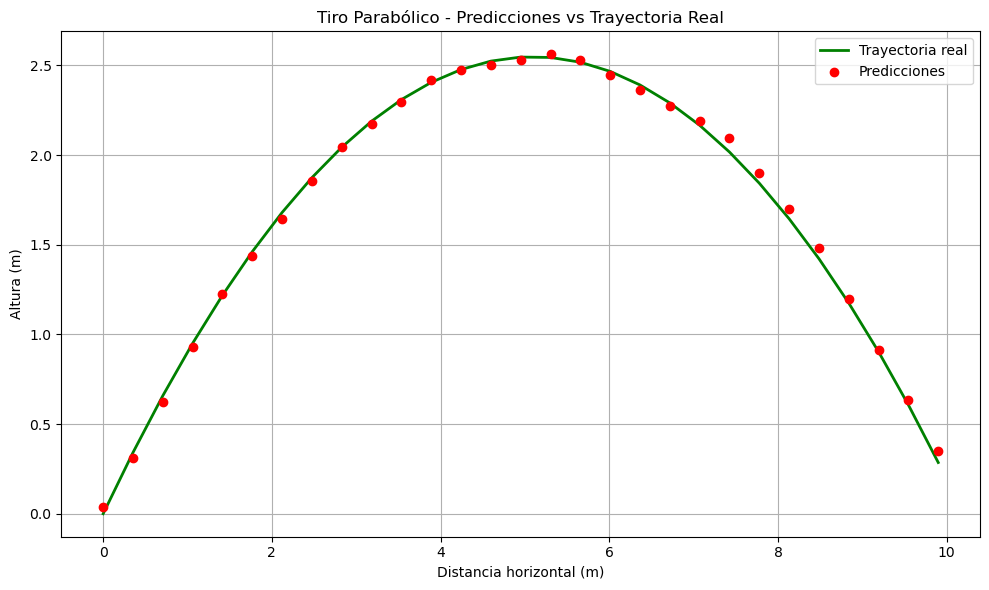

In [43]:
def calcular_trayectoria(v0, theta, g=9.81, t_max=2, dt=0.05):
    t = np.arange(0, t_max, dt)
    x = v0 * np.cos(np.radians(theta)) * t
    y = v0 * np.sin(np.radians(theta)) * t - 0.5 * g * t**2
    trayectoria = np.vstack((x, y)).T
    return trayectoria[y >= 0]  

v0 = 10  
theta = 45  

trayectoria = calcular_trayectoria(v0, theta)

X = torch.tensor(trayectoria[:, 0].reshape(-1, 1), dtype=torch.float32)
with torch.no_grad():
    y_pred = model(X).squeeze().numpy()

plt.figure(figsize=(10, 6))
plt.plot(trayectoria[:, 0], trayectoria[:, 1], color='green', label='Trayectoria real', linewidth=2)
plt.scatter(trayectoria[:, 0], y_pred, color='red', label='Predicciones', zorder=5)
plt.xlabel('Distancia horizontal (m)')
plt.ylabel('Altura (m)')
plt.title('Tiro Parabólico - Predicciones vs Trayectoria Real')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
